## Description
In this notebook, I analyze the data created in notebook 0. I compare images obtained from monoisotopic peak intensities and from regression.  

## Data loading

In [68]:
%matplotlib notebook

In [69]:
from masserstein import Spectrum, estimate_proportions
from pyimzml.ImzMLParser import ImzMLParser
from matplotlib import pyplot as plt
import numpy as np

In [70]:
PC_38_0 = 'C46H92NO8P'
PC_38_1 = 'C46H90NO8P'
PC_38_2 = 'C46H88NO8P'
PC_38_3 = 'C46H86NO8P'
PS_38_1 = 'C44H84NO10P'
PS_38_3 = 'C44H80NO10P'
PS_38_4 = 'C44H78NO10P'
PS_38_5 = 'C44H76NO10P'
PS_38_6 = 'C44H74NO10P'

In [71]:
formulas = [PC_38_0, PC_38_1, PC_38_2, PC_38_3, PS_38_3, PS_38_4, PS_38_5, PS_38_6]
# formulas = [PC_38_0, PC_38_1, PC_38_2, PC_38_3, PS_38_4]
spectra = [Spectrum(f, adduct='K', threshold=0.001) for f in formulas]
for s in spectra:
    s.normalize()

In [72]:
monoisotopic_masses = [s.confs[0][0] for s in spectra]

In [73]:
profile_image = ImzMLParser('lipid_MSI_profile_mode.imzML')
centroid_image = ImzMLParser('lipid_MSI_centroid_mode.imzML')

In [74]:
image_shape = profile_image.coordinates[-1][:2]

In [75]:
image_shape = (image_shape[0]+1, image_shape[1]+1)  
image_shape

(50, 83)

## Ion images

In [76]:
profile_ion_images = np.zeros(image_shape  + (len(spectra), ))
centroid_ion_images = np.zeros(image_shape + (len(spectra), ))

In [77]:
for idx, (x,y,z) in enumerate(profile_image.coordinates):
    mz, intsy = profile_image.getspectrum(idx)
    mz = np.array(mz)
    for i, m in enumerate(monoisotopic_masses):
        peak_id = np.argmin(np.abs(mz-m))
        profile_ion_images[x, y, i] = intsy[peak_id]
    mz, intsy = centroid_image.getspectrum(idx)
    mz = np.array(mz)
    for i, m in enumerate(monoisotopic_masses):
        peak_id = np.argmin(np.abs(mz-m))
        centroid_ion_images[x, y, i] = intsy[peak_id]

<IPython.core.display.Javascript object>


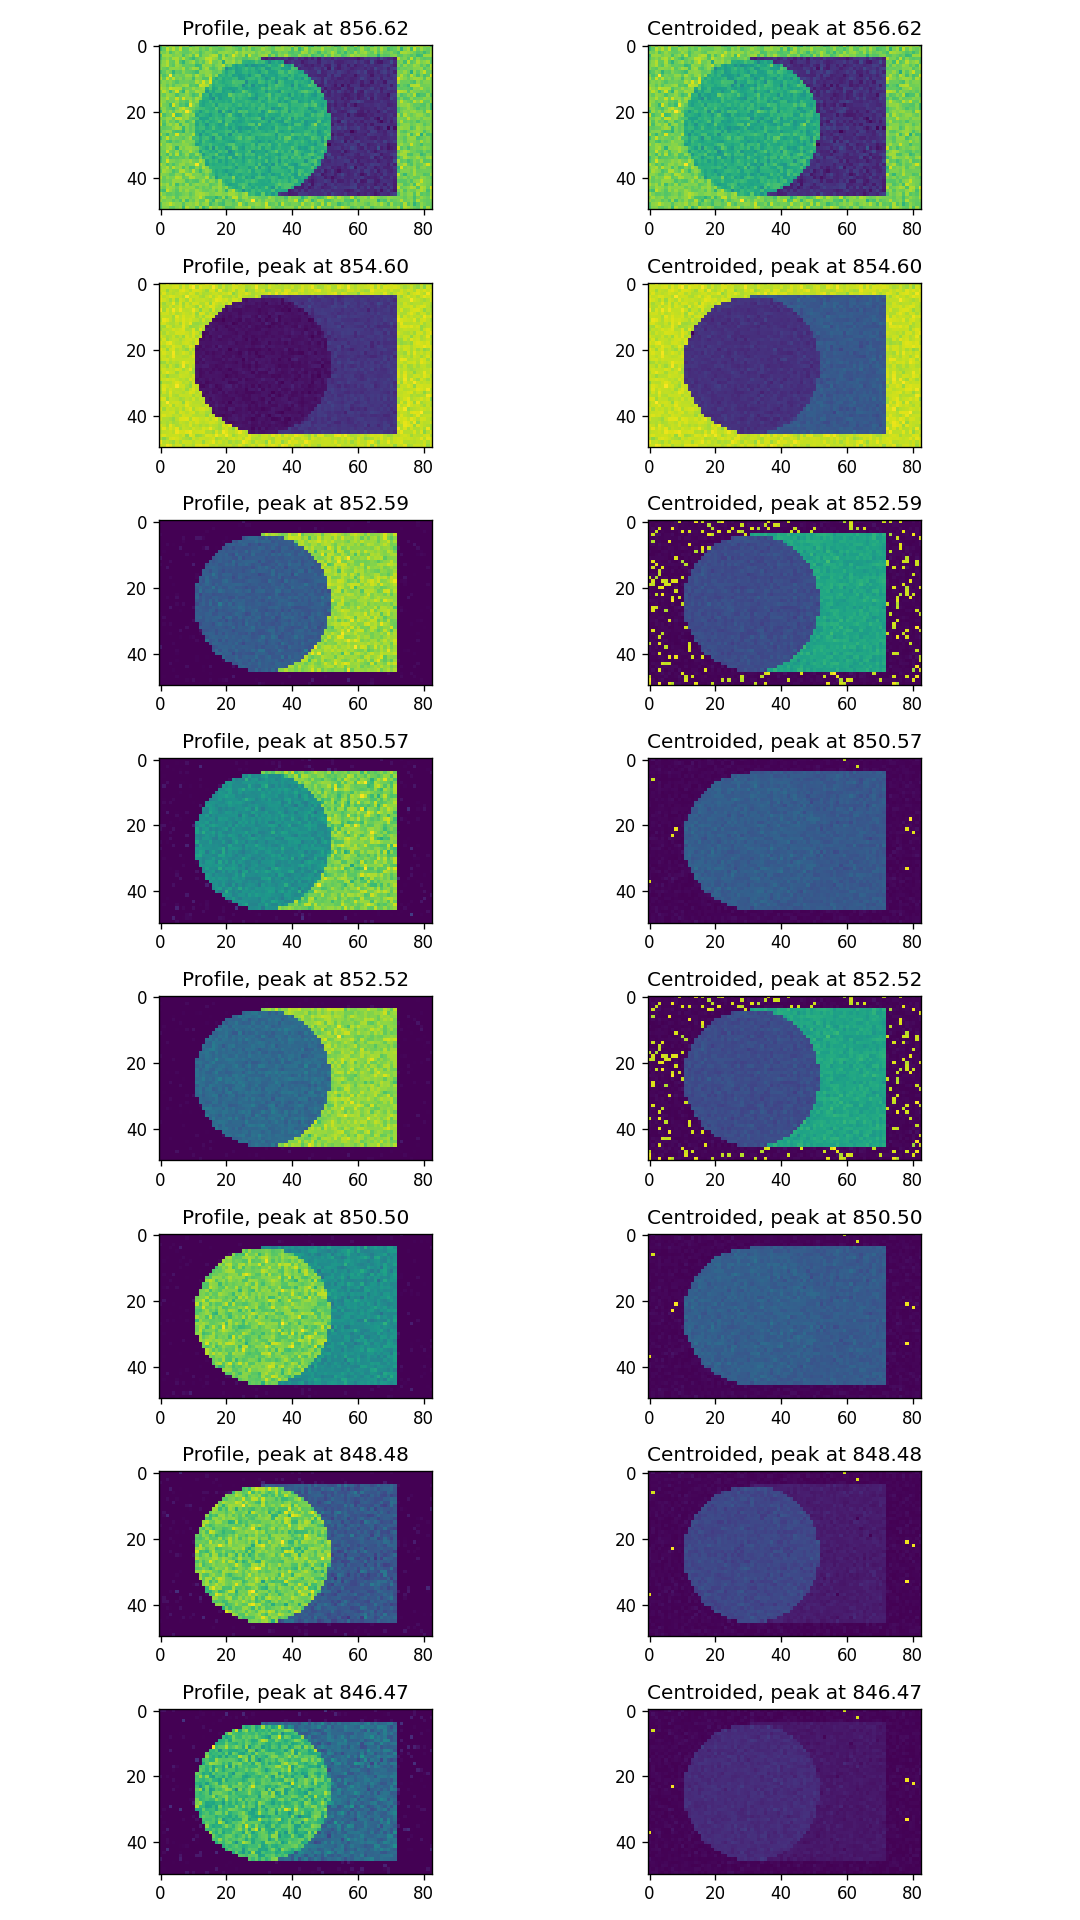

In [78]:
plt.figure(figsize=(9, 2*len(spectra)))
for i in range(len(spectra)):
    plt.subplot(len(spectra), 2, 1+2*i)
    plt.title('Profile, peak at %.2f' % monoisotopic_masses[i])
    plt.imshow(profile_ion_images[:,:,i])
    plt.subplot(len(spectra), 2, 2+2*i)
    plt.title('Centroided, peak at %.2f' % monoisotopic_masses[i])
    plt.imshow(centroid_ion_images[:,:,i])
plt.tight_layout()
plt.show()
plt.savefig('lipid_monoisotopic.pdf')

Compare centroided and profile spectra from the two regions:

In [85]:
idx1 = profile_image.coordinates.index((25, 30, 1))
idx2 = profile_image.coordinates.index((25, 60, 1))

In [86]:
PS1 = Spectrum(confs=list(zip(*profile_image.getspectrum(idx1))))
PS2 = Spectrum(confs=list(zip(*profile_image.getspectrum(idx2))))
CS1 = Spectrum(confs=list(zip(*centroid_image.getspectrum(idx1))))
CS2 = Spectrum(confs=list(zip(*centroid_image.getspectrum(idx2))))

<IPython.core.display.Javascript object>


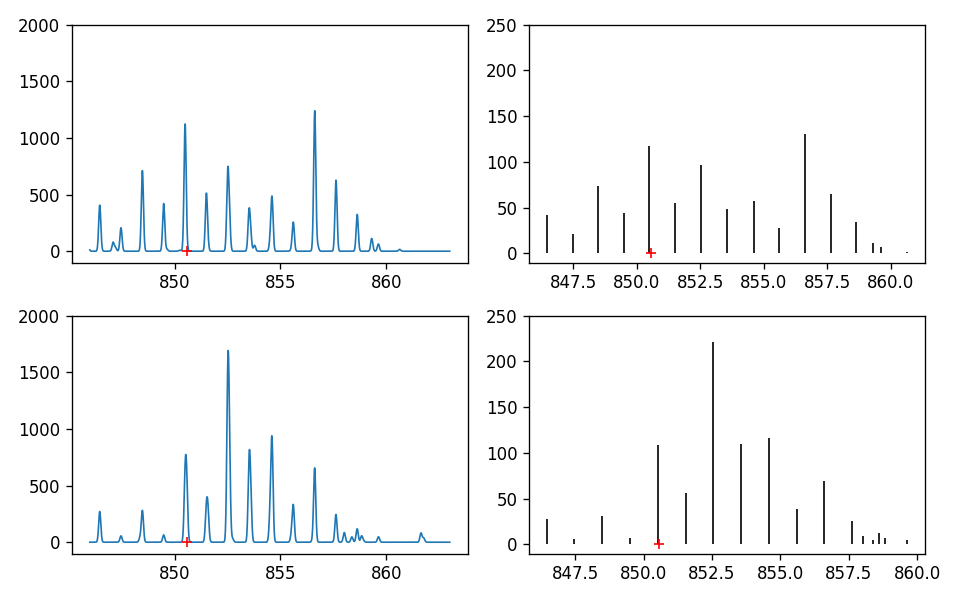

In [87]:
plt.figure(figsize=(8,5))
plt.subplot(221)
PS1.plot(profile=True, show=False)
plt.ylim(-100, 2000)
plt.plot(850.57, 0, 'r+')
plt.subplot(222)
CS1.plot(profile=False, show=False)
plt.ylim(-10, 250)
plt.plot(850.57, 0, 'r+')
plt.subplot(223)
PS2.plot(profile=True, show=False)
plt.ylim(-100, 2000)
plt.plot(850.57, 0, 'r+')
plt.subplot(224)
CS2.plot(profile=False, show=False)
plt.ylim(-10, 250)
plt.plot(850.57, 0, 'r+')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


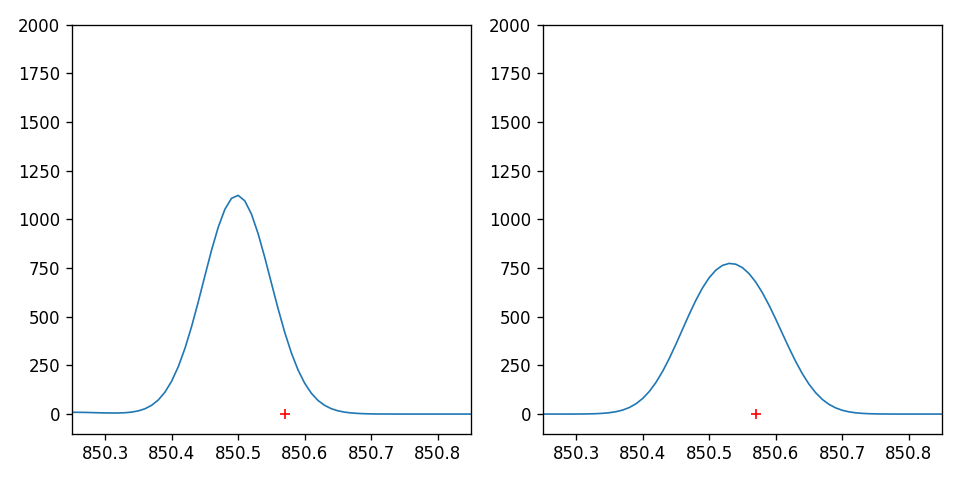

In [88]:
plt.figure(figsize=(8,4))
plt.subplot(121)
PS1.plot(profile=True, show=False)
plt.ylim(-100, 2000)
plt.xlim(850.25, 850.85)
plt.plot(850.57, 0, 'r+')
plt.subplot(122)
PS2.plot(profile=True, show=False)
plt.ylim(-100, 2000)
plt.xlim(850.25, 850.85)
plt.plot(850.57, 0, 'r+')
plt.tight_layout()
plt.show()

Those two peaks have different heights, but similar areas - this is because there are two very similar lipids there with different proportions; On the left, we mostly have one lipid, while on the right the lipids have similar proportions, making the profile peak broader (since their peaks merge due to low resolution)

## Regressed proportion images

In [89]:
profile_regression_images = np.zeros(image_shape  + (len(spectra), ))
centroid_regression_images = np.zeros(image_shape + (len(spectra), ))

In [ ]:
for idx, (x,y,z) in enumerate(profile_image.coordinates):
    if not idx%500:
        print(idx)
    PS = Spectrum(confs=list(zip(*profile_image.getspectrum(idx))))
    PS.normalize()
    CS = Spectrum(confs=list(zip(*profile_image.getspectrum(idx))))
    CS.normalize()
    Preg = estimate_proportions(PS, spectra, MTD=0.5)
    Creg = estimate_proportions(CS, spectra, MTD=0.05)
    profile_regression_images[x,y,:] = Preg['proportions']
    centroid_regression_images[x,y,:] = Creg['proportions']

0
500
1000
1500
2000
2500
3000
3500
4000


<IPython.core.display.Javascript object>


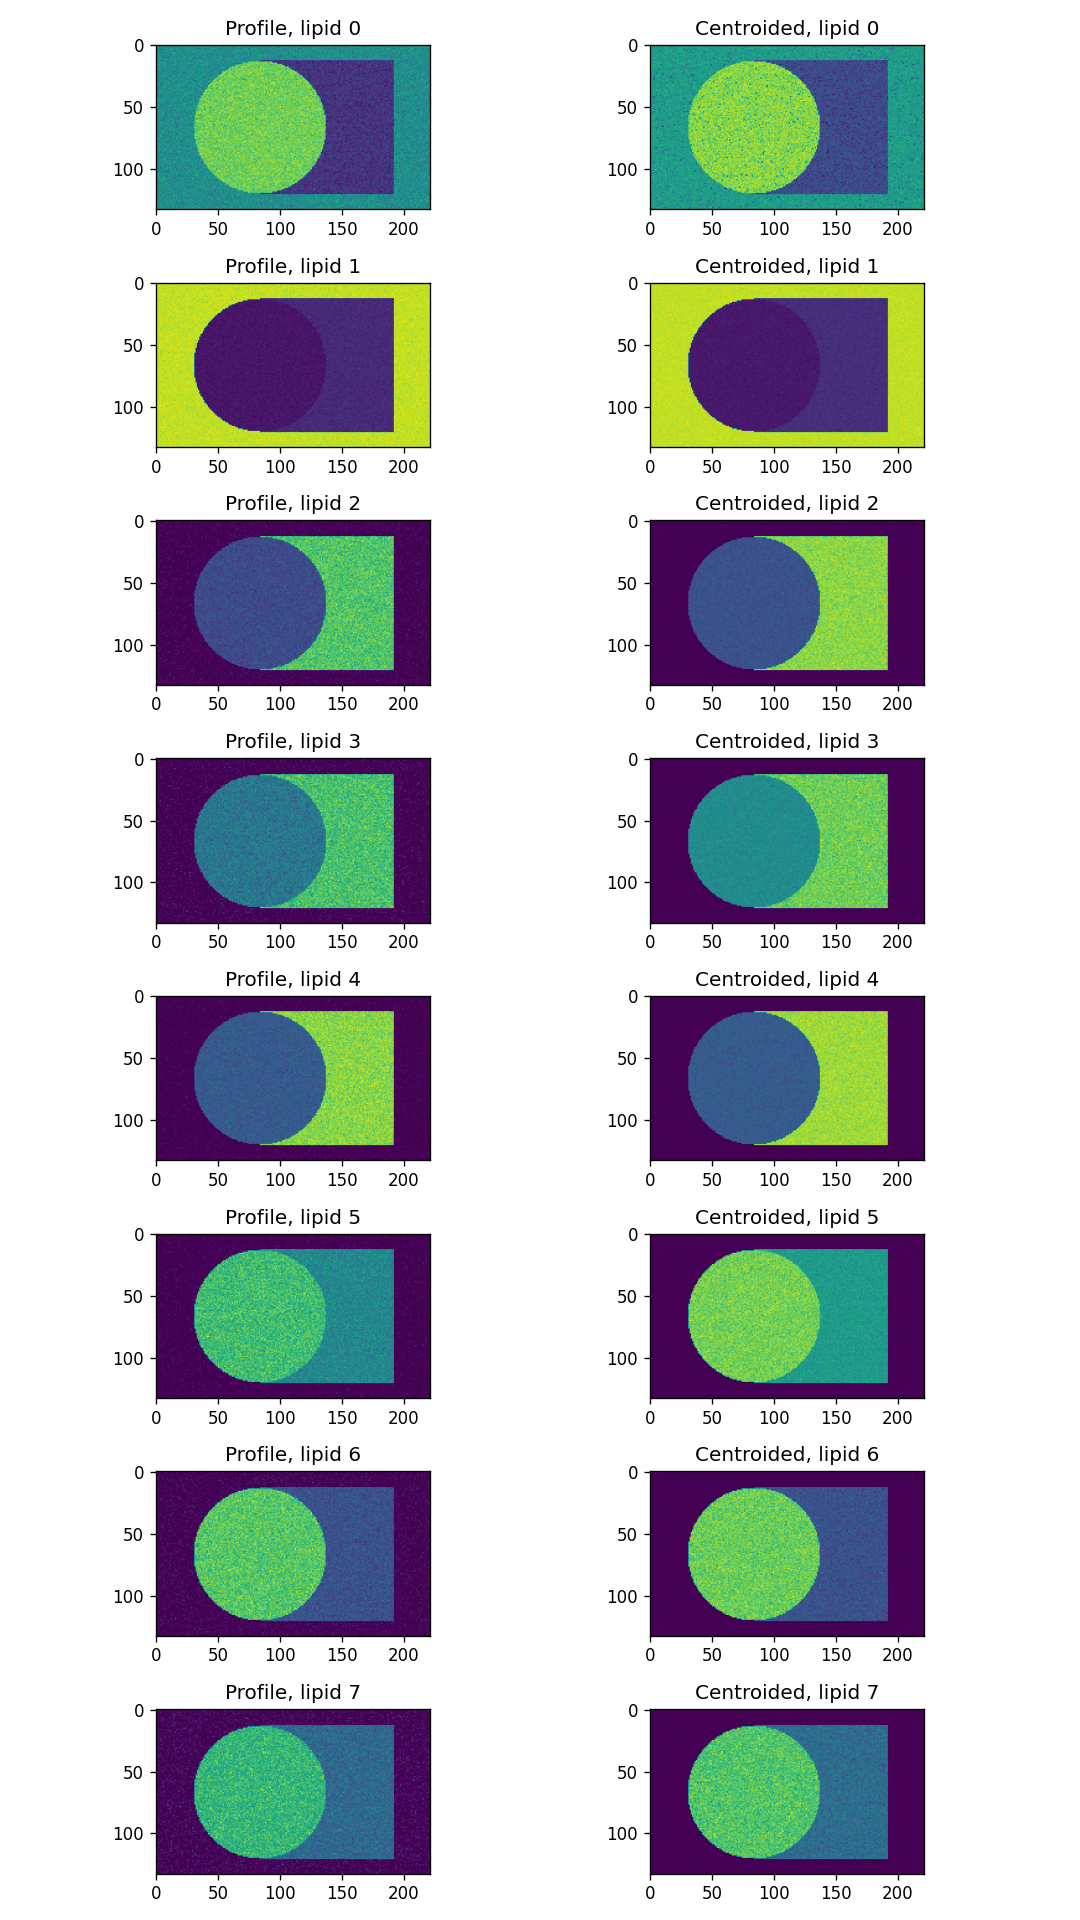

In [65]:
plt.figure(figsize=(9, 2*len(spectra)))
for i in range(len(spectra)):
    plt.subplot(len(spectra), 2, 1+2*i)
    plt.title('Profile, lipid %i' % i)
    plt.imshow(profile_regression_images[:,:,i])
    plt.subplot(len(spectra), 2, 2+2*i)
    plt.title('Centroided, lipid %i' % i)
    plt.imshow(centroid_regression_images[:,:,i])
plt.tight_layout()
plt.show()
plt.savefig('lipid_deconvolution.pdf')